# HSIC

In this notebook, I will be looking at HSIC and replicating some MATLAB code found [here](). There are 3 main functions:
* HSIC
* HSIC Derivative
* Randomized HSIC Derivative

In [2]:
import sys
sys.path.insert(0, '/home/emmanuel/code/kernellib')
from kernellib.dependence import HSIC, RHSIC
import numpy as np
import numba
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.utils.validation import check_array
from sklearn.preprocessing import KernelCenterer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils import check_random_state

from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Parameters

In [24]:
np.random.seed(1234)

num_points = 1000

kernel = RBF()

num_rand_features = 50

## Toy Data

In [25]:
# High Correlation, High Dependence
x1 = np.random.rand(num_points, 1)

y1 = x1 + 0.1 * np.random.randn(num_points, 1)

# Low Correlation, High Dependence
t = 2 * np.pi * np.random.rand(num_points, 1)

x2 = np.cos(t) + 0.1 * np.random.randn(num_points, 1)
y2 = np.sin(t) + 0.1 * np.random.randn(num_points, 1)

# Low Correlation, Low Dependence
x3 = np.random.rand(num_points, 1)
y3 = np.random.rand(num_points, 1)

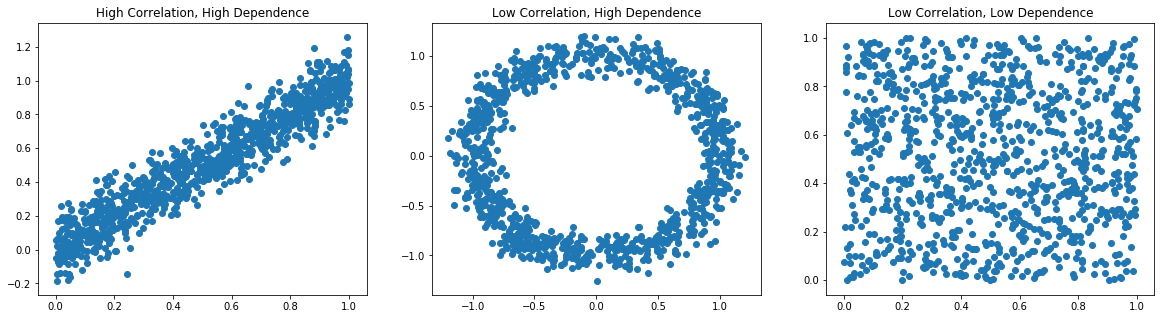

In [26]:
fig, ax = plt.subplots(figsize=(20,5), nrows=1, ncols=3)

ax[0].scatter(x1, y1)
ax[0].set_title('High Correlation, High Dependence')

ax[1].scatter(x2, y2)
ax[1].set_title('Low Correlation, High Dependence')

ax[2].scatter(x3, y3)
ax[2].set_title('Low Correlation, Low Dependence')

plt.show()

## HSIC

In [27]:
class HSIC(object):
    """Kernel Independence Test Function
    
    Parameters
    ----------
    kernel: str, 
    
    """
    def __init__(self, kernel='rbf', random_state=1234):
        self.kernel = RBF()
        self.rng = check_random_state(random_state)
        
        self.hsic_fit = None
    
    def fit(self, X, Y):

        # Random State
        
        
        # Check sizes of X, Y
        X = check_array(X, ensure_2d=True)
        Y = check_array(Y, ensure_2d=True)
        
        assert(X.shape[0] == Y.shape[0])
        
        self.n_samples = X.shape[0]
        self.dx_dimensions = X.shape[1]
        self.dy_dimensions = Y.shape[1]
        
        self.X_train_ = X
        self.Y_train_ = Y
            
        # Estimate sigma parameter (RBF) kernel only
        self.sigma_x = self._estimate_length_scale(X)
        self.sigma_y = self._estimate_length_scale(Y)
        
        # Calculate Kernel Matrices for X, Y
        self.K_x = RBF(self.sigma_x)(X)
        self.K_y = RBF(self.sigma_y)(Y)
        
        # Center Kernel
        self.H = np.eye(self.n_samples) - ( 1 / self.n_samples ) * np.ones(self.n_samples)
        self.K_xc = np.dot(self.K_x, self.H)
        self.K_yc = np.dot(self.K_y, self.H)
        
        # TODO: check kernelcentering (sklearn)
        
        # Compute HSIC value
        self.hsic_value = (1 / (self.n_samples - 1)**2) * np.einsum('ij,ij->', self.K_xc, self.K_yc)
        
        self.hsic_fit = True
        return self
    
    def _estimate_length_scale(self, data):
        
        # Subsample data
        if data.shape[0] > 5e2:
            
            # Random Permutation
            n_sub_samples = self.rng.permutation(data.shape[0])
            
            data = data[n_sub_samples, :]
            
        return np.sqrt(.5 * np.median(pdist(data)**2))
    
    def derivative(self):
        
        # check if HSIC function is fit
        if self.hsic_fit is None:
            raise ValueError("Function isn't fit. Need to fit function to some data.")
        
        factor = ( 2 / ( self.n_samples - 1)**2 )
        
        # X Derivative
        mapX = np.zeros((self.n_samples, self.dx_dimensions))
        HKyH = np.dot(self.H, np.dot(self.K_y, self.H))
        de = np.zeros((1, self.n_samples))
        
        for idx in range(self.dx_dimensions):
            for isample in range(self.n_samples):
                de = ((self.X_train_[isample, idx] - self.X_train_[:, idx]) * self.K_x[:, isample])[:, None]
                mapX[isample, idx] = np.einsum('ji,ij->', HKyH[isample, :][:, None].T, de)
                
        mapX *= factor * (-1 / self.sigma_x**2)
        self.der_x = mapX
        
        # Y Derivative
        mapY = np.zeros((self.n_samples, self.dx_dimensions))
        HKxH = np.dot(self.H, np.dot(self.K_x, self.H))
        de = np.zeros((1, self.n_samples)) 
        
        for idy in range(self.dy_dimensions):
            for isample in range(self.n_samples):
                de = ((self.Y_train_[isample, idy] - self.Y_train_[:, idy]) * self.K_y[:, isample])[:, None]
                mapY[isample, idy] = np.einsum('ji,ij->', HKxH[isample, :][:, None].T , de)
        
        mapY *= factor * (-1 / self.sigma_y**2)
        
        self.der_y = mapY
        
        return mapX, mapY
    
    def sensitivity(self, standard=True):

        if (not hasattr(self, 'der_x')) or (not hasattr(self, 'der_y')):
            print('No derivatives found. Recalculating derivative.')
            self.der_x, self.der_y = self.derivative()
            
        sens = np.sqrt(self.der_x**2 + self.der_y**2)
        
        # standardize
        if standard:
            sens = StandardScaler(with_mean=True, with_std=False).fit_transform(sens)
        
        return sens
    
    def test_estat(self):
        pass



#### Note: Einsum Speedup

In [28]:
# K_xc = hsic_model.K_xc
# K_yc = hsic_model.K_yc

# np.testing.assert_array_almost_equal(np.einsum('ji,ij->', K_xc, K_yc), np.sum(np.sum(K_xc.T * K_yc)))

In [29]:
# %timeit np.einsum('ji,ij->', K_xc, K_yc)

In [30]:
# %timeit np.sum(np.sum(K_xc.T * K_yc))

In [31]:
hsic_vals = dict()
sens = dict()

In [32]:
hsic_model = HSIC(kernel='rbf', random_state=1234)

hsic_model.fit(x1, y1);

hsic_vals['hh'] = hsic_model.hsic_value
sens['hh'] = hsic_model.sensitivity()

# hsic value
print(f"HSIC (H,H): {hsic_vals['hh']}")

No derivatives found. Recalculating derivative.
HSIC (H,H): 0.10420709499567238


In [33]:
# fig, ax = plt.subplots()

# my_colors = [
#     '#ff0000', 
#     '#000000'
# ]

# cmap=LinearSegmentedColormap.from_list('mycmap', my_colors[::-1])

# ax.scatter(x1, y1, c=sens, cmap=cmap)
# ax.set_title('HSIC Sensitivity Map')
# plt.show()

In [34]:
hsic_model = HSIC(kernel='rbf', random_state=1234)

hsic_model.fit(x2, y2);

hsic_vals['lh'] = hsic_model.hsic_value

# hsic value
print(f"HSIC (L,H): {hsic_model.hsic_value}")
      
sens['lh'] = hsic_model.sensitivity()

HSIC (L,H): 0.014218970577379784
No derivatives found. Recalculating derivative.


In [35]:
hsic_model = HSIC(kernel='rbf', random_state=1234)

hsic_model.fit(x3, y3);

hsic_vals['ll'] = hsic_model.hsic_value

# hsic value
print(f"HSIC (L,L): {hsic_model.hsic_value}")
      
sens['ll'] = hsic_model.sensitivity()

HSIC (L,L): 0.00031312418116805
No derivatives found. Recalculating derivative.


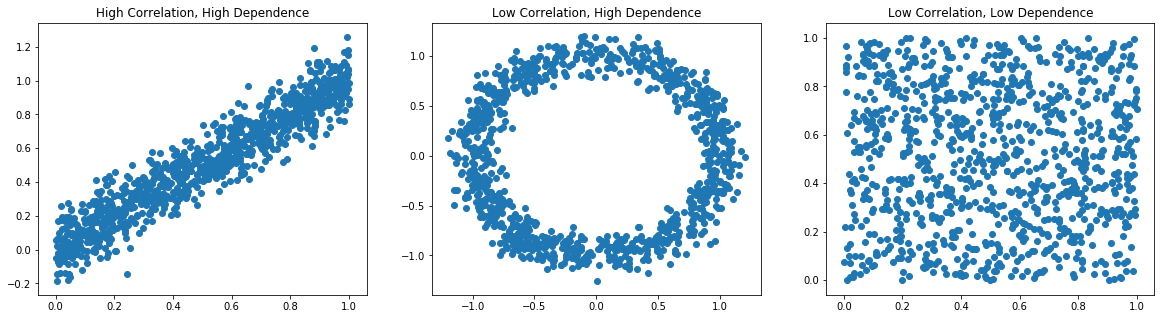

In [36]:
fig, ax = plt.subplots(figsize=(20,5), nrows=1, ncols=3)

ax[0].scatter(x1, y1)
ax[0].set_title('High Correlation, High Dependence')

ax[1].scatter(x2, y2)
ax[1].set_title('Low Correlation, High Dependence')

ax[2].scatter(x3, y3)
ax[2].set_title('Low Correlation, Low Dependence')

plt.show()

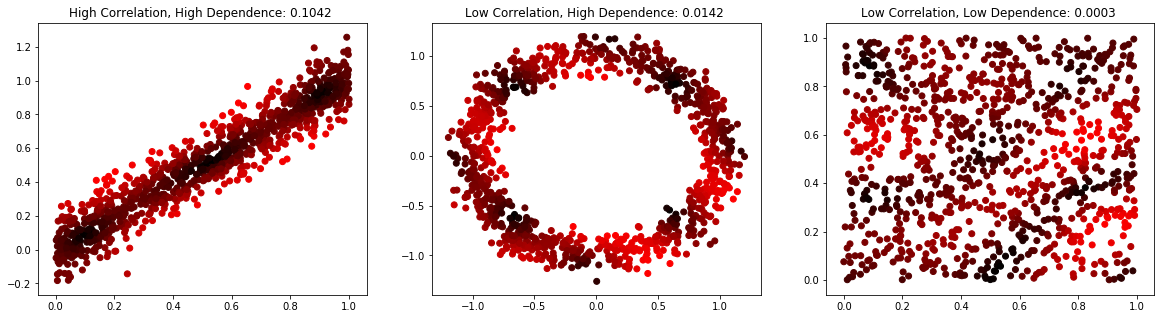

In [37]:
fig, ax = plt.subplots(figsize=(20,5), nrows=1, ncols=3)

my_colors = [
    '#000000',
    '#ff0000', 
    
]

cmap=LinearSegmentedColormap.from_list('mycmap', my_colors)


ax[0].scatter(x1, y1, c=sens['hh'], cmap=cmap)
ax[0].set_title(f"High Correlation, High Dependence: {hsic_vals['hh']:.4f} ")

ax[1].scatter(x2, y2, c=sens['lh'], cmap=cmap)
ax[1].set_title(f"Low Correlation, High Dependence: {hsic_vals['lh']:.4f} ")

ax[2].scatter(x3, y3, c=sens['ll'], cmap=cmap)
ax[2].set_title(f"Low Correlation, Low Dependence: {hsic_vals['ll']:.4f} ")

plt.show()

## Randomized HSIC

In [38]:
class RHSIC(object):
    """Randomized Kernel Independence Test Function
    
    Parameters
    ----------
    kernel: str, 
    
    """
    def __init__(self, kernel='rbf', n_features=10, random_state=1234):
        self.kernel = RBF()
        self.n_features = n_features
        self.rng = check_random_state(random_state)
        self.hsic_fit = None
    
    def fit(self, X, Y):
        
        # Check sizes of X, Y
        X = check_array(X, ensure_2d=True)
        Y = check_array(Y, ensure_2d=True)
        
        assert(X.shape[0] == Y.shape[0])
        
        self.n_samples = X.shape[0]
        self.dx_dimensions = X.shape[1]
        self.dy_dimensions = Y.shape[1]
        
        
        
        factor =  1 / (self.n_samples - 1)**2
        
        self.X_train_ = X
        self.Y_train_ = Y
            
        # Estimate sigma parameter (RBF) kernel only
        self.sigma_x = self._estimate_length_scale(X)
        self.sigma_y = self._estimate_length_scale(Y)
        
        # =================================
        # Calculate Kernel Matrices for X
        # =================================
        # Generate n_components iid samples (Random Projection Matrix)
        self.Wx = (1 / self.sigma_x) * self.rng.randn(self.dx_dimensions, self.n_features)

        # Explicitly project the features
        self.Zx = (1 / np.sqrt(self.n_features)) * np.exp(1j * X @ self.Wx)
        
        # Remove the Mean
        self.Zxc = self.Zx - np.mean(self.Zx, axis=0)
#         import pdb; pdb.set_trace()

        # =================================
        # Calculate Kernel Matrices for Y
        # =================================
        
        # Calcualte Kernel Matrix for Y
        self.Wy = (1 / self.sigma_y) * self.rng.randn(self.dy_dimensions, self.n_features)
        self.Zy = (1 / np.sqrt(self.n_features)) * np.exp(1j * Y @ self.Wy)
        self.Zyc = self.Zy - np.mean(self.Zy, axis=0)
        
        # ====================
        # Compute HSIC Value
        # ====================
        if self.n_features < self.n_samples:
            Rxy = self.Zxc.T @ self.Zyc
#             rh = factor * np.real(np.einsum('ij,ij->', Rxy, Rxy))
            rh = factor * np.real(np.trace(Rxy @ Rxy.T))
        else:
            Zxx = self.Zx @ self.Zxc.T
            Zyy = self.Zy @ self.Zyc.T
#             rh = factor * np.real(Zxx @ Zyy).sum().sum()
            rh = factor * np.real(np.einsum('ij,ji->', Zxx, Zyy))
            
        self.hsic_value = rh
        
        self.hsic_fit = True
        return self
    
    def _estimate_length_scale(self, data):
        
        # Subsample data
        if data.shape[0] > 5e2:
            
            # Random Permutation
            n_sub_samples = self.rng.permutation(data.shape[0])
            
            data = data[n_sub_samples, :]
            
        return np.sqrt(.5 * np.median(pdist(data)**2))
    
    def derivative(self):
        
        if self.hsic_fit is None:
            raise ValueError("Function isn't fit. Need to fit function to some data.")
            
        factor =  1 / (self.n_samples - 1)**2
        
        mapX = np.zeros((self.X_train_.shape))
        Jx = np.zeros((1, self.dx_dimensions))
        mapY = np.zeros((self.Y_train_.shape))
        Jy = np.zeros((1, self.dy_dimensions))
        
        np.testing.assert_array_almost_equal(
            self.Zyc @ (self.Zyc.T @ self.Zx),
            (self.Zyc @ self.Zyc.T) @ self.Zx
        )
        
        # =============================
        # Case I: Samples < Features
        # =============================
#         if self.n_features < self.n_samples:
            
        BBx = self.Zyc @ (self.Zyc.T @ self.Zx)
        BBy = self.Zxc @ (self.Zxc.T @ self.Zy)

        # X Term

        for idim in range(self.dx_dimensions):
            for isample in range(self.n_samples):
                Jx[idim] = 1
                aux = 1j * Jx @ self.Wx
                Jx[idim] = 0
                derX = self.Zx[isample, :] * aux
#                     print(mapX[isample, idim].shape, BBx[isample, :][None, :].shape, derX.T.shape, )
                mapX[isample, idim] = np.real(BBx[isample, :][None, :] @ derX.T).squeeze()

        mapX = factor * mapX

        # Y Term

        for idim in range(self.dy_dimensions):
            for isample in range(self.n_samples):
                Jy[idim] = 1
                aux = 1j * Jy @ self.Wy
                Jy[idim] = 0
                derY = self.Zy[isample, :] * aux
#                     print(mapX[isample, idim].shape, BBx[isample, :][None, :].shape, derX.T.shape, )
                mapY[isample, idim] = np.real(BBy[isample, :][None, :] @ derY.T).squeeze()

        mapY = factor * mapY
        
#         # =============================
#         # Case II: Samples > Features
#         # =============================
#         else:

#             # X Term
#             BBx = (self.Zyc @ self.Zyc.T) @ self.Zx

#             for idim in range(self.dx_dimensions):
#                 for isample in range(self.n_samples):
#                     Jx[idim] = 1
#                     aux = 1j * Jx @ self.Wx
#                     Jx[idim] = 0
#                     derX = self.Zx[isample, :] * aux
# #                     print(mapX[isample, idim].shape, BBx[isample, :][None, :].shape, derX.T.shape, )
#                     mapX[isample, idim] = np.real(BBx[isample, :][None, :] @ derX.T).squeeze()

#             mapX = factor * mapX
            
#             # Y Term
#             BBy = (self.Zxc @ self.Zxc.T) @ self.Zy
            
#             for idim in range(self.dy_dimensions):
#                 for isample in range(self.n_samples):
#                     Jy[idim] = 1
#                     aux = 1j * Jy @ self.Wy
#                     Jy[idim] = 0
#                     derY = self.Zy[isample, :] * aux
# #                     print(mapX[isample, idim].shape, BBx[isample, :][None, :].shape, derX.T.shape, )
#                     mapY[isample, idim] = np.real(BBy[isample, :][None, :] @ derY.T).squeeze()

#             mapY = factor * mapY
        
        self.der_X = mapX
        self.der_Y = mapY
        return mapX, mapY
    
    def sensitivity(self, standard=True):
        
        if (not hasattr(self, 'der_X')) or (not hasattr(self, 'der_Y')):
            print('No derivatives found. Recalculating derivative.')
            self.der_X, self.der_Y = self.derivative()
            
        sens = np.sqrt(self.der_X**2 + self.der_Y**2)
        
        # standardize
        if standard:
            sens = StandardScaler(with_mean=True, with_std=False).fit_transform(sens)
        
        return sens

In [39]:
hsic_vals

In [40]:
rhsic_model = RHSIC(kernel='rbf', n_features=50, random_state=1234)

rhsic_model.fit(x1, y1);

# hsic_vals['hh']  = 
hsic_vals['rhh'] = rhsic_model.hsic_value
derX, derY = rhsic_model.derivative()
sens['rhh'] = rhsic_model.sensitivity()

# hsic value
print(f"RHSIC (H,H): {rhsic_model.hsic_value:.4f}")

RHSIC (H,H): 0.0151


In [41]:
# fig, ax = plt.subplots()

# ax.plot(rhsic_model.Wx.squeeze())
# ax.plot(rhsic_model.Wy.squeeze())

# plt.show()

# fig, ax = plt.subplots(figsize=(10,5))

# ax.imshow( np.real(rhsic_model.Zx))
# # ax.scatter(np.real(rhsic_model.Zy).squeeze())

# plt.show()

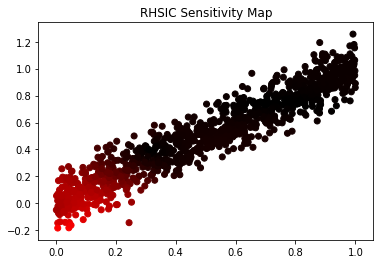

In [42]:
fig, ax = plt.subplots()

my_colors = [
    '#ff0000', 
    '#000000'
]

cmap=LinearSegmentedColormap.from_list('mycmap', my_colors[::-1])

ax.scatter(x1, y1, c=sens['rhh'], cmap=cmap)
ax.set_title('RHSIC Sensitivity Map')
plt.show()

In [43]:
rhsic_model = RHSIC(kernel='rbf', n_features=50, random_state=1234)

rhsic_model.fit(x2, y2);

# hsic_vals['hh']  = 
hsic_vals['rlh'] = rhsic_model.hsic_value
sens['rlh'] = rhsic_model.sensitivity()

# hsic value
print(f"RHSIC (H,H): {rhsic_model.hsic_value:.4f}")

No derivatives found. Recalculating derivative.
RHSIC (H,H): 0.0145


In [44]:
rhsic_model = RHSIC(kernel='rbf', n_features=50, random_state=1234)

rhsic_model.fit(x3, y3);

# hsic_vals['hh']  = 
hsic_vals['rll'] = rhsic_model.hsic_value
sens['rll'] = rhsic_model.sensitivity()

# hsic value
print(f"RHSIC (H,H): {rhsic_model.hsic_value:.4f}")

No derivatives found. Recalculating derivative.
RHSIC (H,H): -0.0000


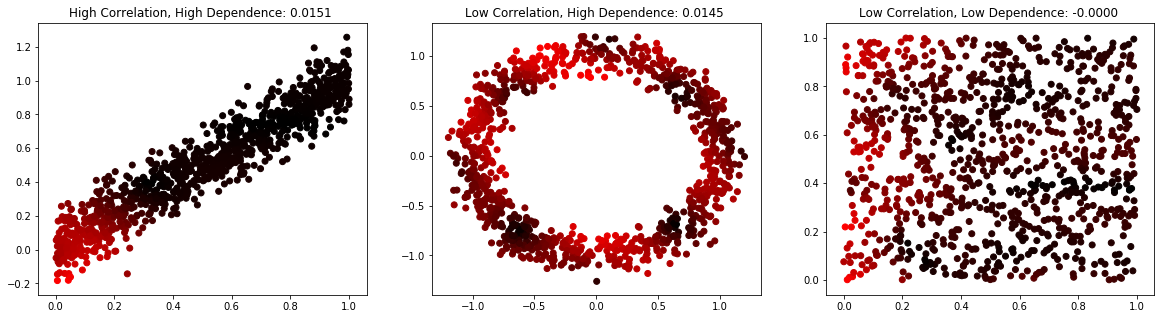

In [45]:
fig, ax = plt.subplots(figsize=(20,5), nrows=1, ncols=3)

my_colors = [
    '#000000',
    '#ff0000', 
    
]

cmap=LinearSegmentedColormap.from_list('mycmap', my_colors)


ax[0].scatter(x1, y1, c=sens['rhh'], cmap=cmap)
ax[0].set_title(f"High Correlation, High Dependence: {hsic_vals['rhh']:.4f} ")

ax[1].scatter(x2, y2, c=sens['rlh'], cmap=cmap)
ax[1].set_title(f"Low Correlation, High Dependence: {hsic_vals['rlh']:.4f} ")

ax[2].scatter(x3, y3, c=sens['rll'], cmap=cmap)
ax[2].set_title(f"Low Correlation, Low Dependence: {hsic_vals['rll']:.4f} ")

plt.show()